In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image, ImageFile

from tqdm import tqdm


In [7]:
# Load the pre-trained ResNet model
model = models.resnet18(pretrained=True)

/home/py/Documents/crying-irl/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/py/Documents/crying-irl/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Change the output layer to 1 output

In [17]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(torch.cuda.is_available())

True


In [18]:
# Define a custom dataset
class WildfireDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = list(directory.glob('*.jpg')) 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data_path = "../data/train"

ImageFile.LOAD_TRUNCATED_IMAGES = True

def tolerant_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except IOError as e:
        print(f"Could not load image {path}: {e}, skipping.")

# Replace the default loader with the tolerant loader
datasets.ImageFolder.loader = tolerant_loader


# Create the dataset using ImageFolder
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)

# Create a DataLoader to feed data to your model
batch = 64
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=4, pin_memory=True)

In [34]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop (simplified for illustration)
num_epochs = 100

pbar = tqdm(train_dataset)
train_len = len(train_dataset)

for epoch in range(num_epochs):
    epoch += 1

    model.train()
    running_loss = 0.0
    

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_description(f"Processing {i}/{train_len / batch} batches")

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
    
    # Save model checkpoint at the end of each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss,
    }, f'model_epoch_{epoch}.pth')

print("Training complete")

Processing 472/472.65625 batches:   0%|          | 0/30250 [00:34<?, ?it/s]

Epoch 2/100, Loss: 0.05408162181019531


Processing 472/472.65625 batches:   0%|          | 0/30250 [01:10<?, ?it/s]

Epoch 3/100, Loss: 0.03347621953122743


Processing 472/472.65625 batches:   0%|          | 0/30250 [01:47<?, ?it/s]

Epoch 4/100, Loss: 0.019289507557456845


Processing 472/472.65625 batches:   0%|          | 0/30250 [02:24<?, ?it/s]

Epoch 5/100, Loss: 0.009899097638023548


Processing 472/472.65625 batches:   0%|          | 0/30250 [03:01<?, ?it/s]

Epoch 6/100, Loss: 0.007414266692233778


Processing 472/472.65625 batches:   0%|          | 0/30250 [03:38<?, ?it/s]

Epoch 7/100, Loss: 0.0039529627513058725


Processing 472/472.65625 batches:   0%|          | 0/30250 [04:15<?, ?it/s]

Epoch 8/100, Loss: 0.0035400662452622906


Processing 472/472.65625 batches:   0%|          | 0/30250 [04:52<?, ?it/s]

Epoch 9/100, Loss: 0.0026315963842086965


Processing 472/472.65625 batches:   0%|          | 0/30250 [05:29<?, ?it/s]

Epoch 10/100, Loss: 0.0014452502180086414


Processing 472/472.65625 batches:   0%|          | 0/30250 [06:06<?, ?it/s]

Epoch 11/100, Loss: 0.0013442660670089546


Processing 472/472.65625 batches:   0%|          | 0/30250 [06:43<?, ?it/s]

Epoch 12/100, Loss: 0.0006877737841259697


Processing 472/472.65625 batches:   0%|          | 0/30250 [07:20<?, ?it/s]

Epoch 13/100, Loss: 0.0008315148248088503


Processing 472/472.65625 batches:   0%|          | 0/30250 [07:57<?, ?it/s]

Epoch 14/100, Loss: 0.0007935469068222906


Processing 472/472.65625 batches:   0%|          | 0/30250 [08:34<?, ?it/s]

Epoch 15/100, Loss: 0.00043265777387001346


Processing 472/472.65625 batches:   0%|          | 0/30250 [09:10<?, ?it/s]

Epoch 16/100, Loss: 0.0005456297932462863


Processing 472/472.65625 batches:   0%|          | 0/30250 [09:47<?, ?it/s]

Epoch 17/100, Loss: 0.0005705414750664743


Processing 472/472.65625 batches:   0%|          | 0/30250 [10:24<?, ?it/s]

Epoch 18/100, Loss: 0.0003270476627740959


Processing 472/472.65625 batches:   0%|          | 0/30250 [11:01<?, ?it/s]

Epoch 19/100, Loss: 0.00028521451997459875


Processing 472/472.65625 batches:   0%|          | 0/30250 [11:38<?, ?it/s]

Epoch 20/100, Loss: 0.0002907679965687508


Processing 472/472.65625 batches:   0%|          | 0/30250 [12:14<?, ?it/s]

Epoch 21/100, Loss: 0.0003902887116847556


Processing 472/472.65625 batches:   0%|          | 0/30250 [12:51<?, ?it/s]

Epoch 22/100, Loss: 0.00022836718606597932


Processing 472/472.65625 batches:   0%|          | 0/30250 [13:28<?, ?it/s]

Epoch 23/100, Loss: 0.00018869402645647015


Processing 472/472.65625 batches:   0%|          | 0/30250 [14:04<?, ?it/s]

Epoch 24/100, Loss: 0.00015126641404385045


Processing 472/472.65625 batches:   0%|          | 0/30250 [14:41<?, ?it/s]

Epoch 25/100, Loss: 0.00023891757212177888


Processing 472/472.65625 batches:   0%|          | 0/30250 [15:18<?, ?it/s]

Epoch 26/100, Loss: 0.00023811463954158328


Processing 472/472.65625 batches:   0%|          | 0/30250 [15:55<?, ?it/s]

Epoch 27/100, Loss: 0.00019039990003787122


Processing 472/472.65625 batches:   0%|          | 0/30250 [16:31<?, ?it/s]

Epoch 28/100, Loss: 0.0003590653119388866


Processing 472/472.65625 batches:   0%|          | 0/30250 [17:08<?, ?it/s]

Epoch 29/100, Loss: 0.00015628882350694312


Processing 472/472.65625 batches:   0%|          | 0/30250 [17:45<?, ?it/s]

Epoch 30/100, Loss: 0.00018999283418406104


Processing 472/472.65625 batches:   0%|          | 0/30250 [18:22<?, ?it/s]

Epoch 31/100, Loss: 0.00014594620096187555


Processing 472/472.65625 batches:   0%|          | 0/30250 [18:59<?, ?it/s]

Epoch 32/100, Loss: 0.00012484016940777877


Processing 472/472.65625 batches:   0%|          | 0/30250 [19:35<?, ?it/s]

Epoch 33/100, Loss: 0.00018595415890106933


Processing 472/472.65625 batches:   0%|          | 0/30250 [20:12<?, ?it/s]

Epoch 34/100, Loss: 0.0001163968114614811


Processing 472/472.65625 batches:   0%|          | 0/30250 [20:48<?, ?it/s]

Epoch 35/100, Loss: 0.00010663483993634737


Processing 472/472.65625 batches:   0%|          | 0/30250 [21:25<?, ?it/s]

Epoch 36/100, Loss: 0.00011733084451682158


Processing 472/472.65625 batches:   0%|          | 0/30250 [22:02<?, ?it/s]

Epoch 37/100, Loss: 0.00010732908365697485


Processing 472/472.65625 batches:   0%|          | 0/30250 [22:38<?, ?it/s]

Epoch 38/100, Loss: 7.898334267259378e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [23:15<?, ?it/s]

Epoch 39/100, Loss: 6.630017738580347e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [23:52<?, ?it/s]

Epoch 40/100, Loss: 0.0001040302490625184


Processing 472/472.65625 batches:   0%|          | 0/30250 [24:28<?, ?it/s]

Epoch 41/100, Loss: 0.0010265055335649579


Processing 472/472.65625 batches:   0%|          | 0/30250 [25:05<?, ?it/s]

Epoch 42/100, Loss: 0.00023231825366613388


Processing 472/472.65625 batches:   0%|          | 0/30250 [25:41<?, ?it/s]

Epoch 43/100, Loss: 0.00012842105161998878


Processing 472/472.65625 batches:   0%|          | 0/30250 [26:18<?, ?it/s]

Epoch 44/100, Loss: 0.0002195592601546182


Processing 472/472.65625 batches:   0%|          | 0/30250 [26:54<?, ?it/s]

Epoch 45/100, Loss: 0.00013217191030793666


Processing 472/472.65625 batches:   0%|          | 0/30250 [27:31<?, ?it/s]

Epoch 46/100, Loss: 8.139267044381118e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [28:08<?, ?it/s]

Epoch 47/100, Loss: 7.623104459859685e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [28:45<?, ?it/s]

Epoch 48/100, Loss: 6.150308275812487e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [29:21<?, ?it/s]

Epoch 49/100, Loss: 5.717179637133132e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [29:58<?, ?it/s]

Epoch 50/100, Loss: 6.644506345166008e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [30:35<?, ?it/s]

Epoch 51/100, Loss: 7.685176655840113e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [31:12<?, ?it/s]

Epoch 52/100, Loss: 7.013781494685355e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [31:48<?, ?it/s]

Epoch 53/100, Loss: 5.269540598077291e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [32:25<?, ?it/s]

Epoch 54/100, Loss: 7.582322120852694e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [33:02<?, ?it/s]

Epoch 55/100, Loss: 4.81152830626433e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [33:38<?, ?it/s]

Epoch 56/100, Loss: 4.734593594442887e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [34:15<?, ?it/s]

Epoch 57/100, Loss: 4.8646094342796286e-05


Processing 472/472.65625 batches:   0%|          | 0/30250 [34:51<?, ?it/s]

Epoch 58/100, Loss: 0.0001247916646263161


Processing 472/472.65625 batches:   0%|          | 0/30250 [35:28<?, ?it/s]

Epoch 59/100, Loss: 0.00010037368986993716


Processing 137/472.65625 batches:   0%|          | 0/30250 [35:39<?, ?it/s]

KeyboardInterrupt: 

In [4]:
# Example transformation, adjust according to your needs
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to load and transform an image
def process_image(image_path):
    image = Image.open(image_path)
    image = transform(image).float()
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

test_data_path = "../data/test"
test_set = datasets.ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch, shuffle=False, num_workers=4, pin_memory=True)

In [47]:
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast

for i in range(1, 60):
    checkpoint = torch.load(f"model_epoch_{i}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device)
    predictions = []
    labels = []
    
    with torch.no_grad():
        with autocast():
            for inputs, actual in test_loader:  # Labels are not needed
                inputs = inputs.to(device)
                outputs = model(inputs)

                # Assuming a single-class classification, get the predicted classes
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                labels.extend(actual.cpu().numpy())  
#                 print("i")

    accuracy = accuracy_score(labels, predictions)
    print(f"Model-{i} Accuracy: {accuracy:.4f}")

    
# At this point, 'predictions' contains the predicted class indices for all test images
    
    

Model-1 Accuracy: 0.9725
Model-2 Accuracy: 0.9552
Model-3 Accuracy: 0.9467
Model-4 Accuracy: 0.9156
Model-5 Accuracy: 0.9516
Model-6 Accuracy: 0.9502
Model-7 Accuracy: 0.9552
Model-8 Accuracy: 0.9454
Model-9 Accuracy: 0.9387
Model-10 Accuracy: 0.9473
Model-11 Accuracy: 0.9413
Model-12 Accuracy: 0.9530
Model-13 Accuracy: 0.9425
Model-14 Accuracy: 0.9370
Model-15 Accuracy: 0.9444
Model-16 Accuracy: 0.9532
Model-17 Accuracy: 0.9444
Model-18 Accuracy: 0.9427
Model-19 Accuracy: 0.9362
Model-20 Accuracy: 0.9449
Model-21 Accuracy: 0.9400
Model-22 Accuracy: 0.9432
Model-23 Accuracy: 0.9387
Model-24 Accuracy: 0.9314
Model-25 Accuracy: 0.9483
Model-26 Accuracy: 0.9330
Model-27 Accuracy: 0.9519
Model-28 Accuracy: 0.9570
Model-29 Accuracy: 0.9517
Model-30 Accuracy: 0.9516
Model-31 Accuracy: 0.9414
Model-32 Accuracy: 0.9424
Model-33 Accuracy: 0.9422
Model-34 Accuracy: 0.9495
Model-35 Accuracy: 0.9489
Model-36 Accuracy: 0.9437
Model-37 Accuracy: 0.9343
Model-38 Accuracy: 0.9440
Model-39 Accuracy: 0.

FileNotFoundError: [Errno 2] No such file or directory: 'model_epoch_59.pth'

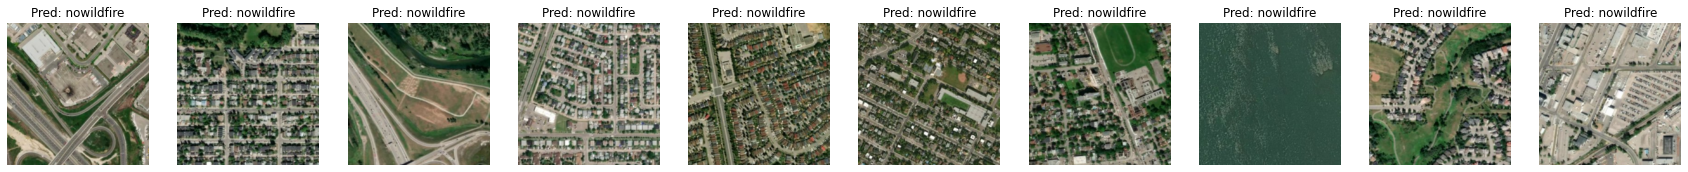

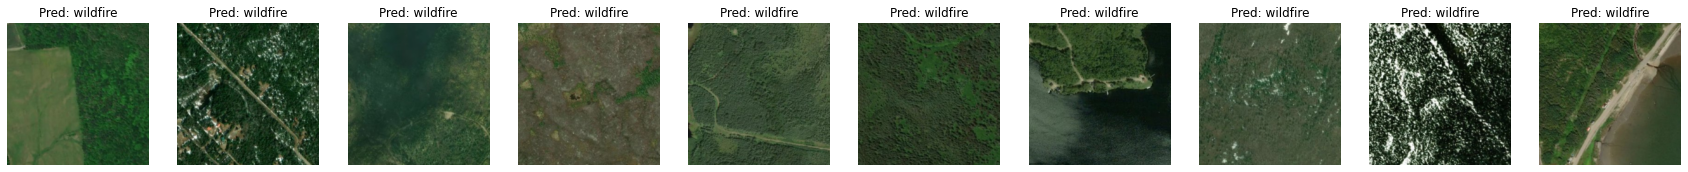

In [62]:
import random
import matplotlib.pyplot as plt
import numpy as np

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Loading the dataset
dataset = datasets.ImageFolder(root='../data/test', transform=transform)

classes = dataset.classes

# Sample 10 random indices for each class
indices = {class_name: random.sample([i for i, (_, class_idx) in enumerate(dataset.samples) if dataset.classes[class_idx] == class_name], 10) for class_name in classes}

# Create a subset for each class
subsets = {class_name: torch.utils.data.Subset(dataset, indices) for class_name, indices in indices.items()}

batch_size = 10  # As we have 10 images per class
dataloaders = {class_name: DataLoader(subset, batch_size=batch_size, shuffle=False) for class_name, subset in subsets.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(f"model_epoch_1.pth")
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)
model.eval()

for class_name, dataloader in dataloaders.items():
    images, _ = next(iter(dataloader))
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu()
    
    fig, axes = plt.subplots(1, 10, figsize=(30, 3))
    for i, (image, pred) in enumerate(zip(images, preds)):
        ax = axes[i]
        img = image.numpy().transpose((1, 2, 0))
        img = std * img + mean  # unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Pred: {classes[pred]}')
        ax.axis('off')

    plt.show()


In [10]:
checkpoint = torch.load(f"../model_epoch_1.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)
model.eval()

single = datasets.ImageFolder("../data/field", transform=transform)
single_loader = DataLoader(single, shuffle=False, num_workers=4, pin_memory=True)

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 512]) from checkpoint, the shape in current model is torch.Size([1000, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1000]).

In [ ]:
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.img_paths = list(self.img_dir.glob('*.png')) 

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        filename = img_path.name 
        image = read_image(str(img_path)) 
        if self.transform:
            image = transforms.ToPILImage()(image)
            image = self.transform(image)
        return image, filename 

single = CustomImageDataset("../data/field", transform=transform)
single_loader = DataLoader(single, shuffle=False, pin_memory=True)
print(len(single))

In [ ]:
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for images, filenames in single_loader:  # single_loader now also yields filenames
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(zip(preds.cpu().numpy(), filenames))
        

In [ ]:
pred_dict = {}

for pred, filename in predictions:
    pred_class = dataset.classes[pred]
#     print(f"{filename}:{pred_class}")
    pred_dict[filename] = pred_class

print(pred_dict)